# Using the XBBG module to extract and analyze bond data for corporate hybrids

# written by: Darren Lefcoe
Jun 2020

contact:
* gitHub: @dlefcoe
* twitter: @dlefcoe
* email: darren@redhedge.uk


## Redhedge Asset Management

Darren Lefcoe uses open source to create and write code for RedHedge.

Running an open source project, like any human endeavor, involves uncertainty and trade-offs.

Please refer to the open source licences:
https://opensource.guide/notices/


# First we do the imports

In [2]:
import os
import sys

import time
import datetime
import collections

import blpapi
from xbbg import blp

import openpyxl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


from sklearn import linear_model
import numpy as np



In [4]:
# given limit for bloomberg data
bloombergLimit = 500_000



In [6]:
# get the file path of this file
dir_path = os.path.abspath('')



In [8]:
# define a list of bond fields
fieldList = ['ticker', 'coupon', 'nxt_call_dt', 'final_maturity', 
            'mty_typ', 'px_mid', 'z_sprd_mid', 'yas_ispread', 'yas_bond_yld', 
            'yas_risk','crncy', 'payment_rank', 'industry_sector','rtg_moody','rtg_sp']




In [10]:
# define bond list

# get items from sheet (in the same folder)
fileToGet = 'hybridSecurityList.xlsx'

# join file and correct folder
fileToGet = os.path.join(dir_path, fileToGet)
secListXlsx = pd.ExcelFile(fileToGet)

# the names of the available sheets
print('getting security list from:', secListXlsx.sheet_names)



getting security list from: ['worksheets', 'tickers']


In [12]:

# put bond list into a pandas dataframe
df = pd.DataFrame(secListXlsx.parse('tickers'))




# Lets see the bond list data

In [14]:
df


,QJ937853 Corp,XS1323897485,SOLBBB 5.118 PERP nc-21
0,EJ917655 Corp,XS0992293901,SOLBBB 5.425 PERP nc-23
1,AV915324 Corp,BE6309987400,SOLBBB 4 1/4 PERP nc-23
2,QJ937566 Corp,XS1323897725,SOLBBB 5.869 PERP nc-24
3,EK834863 Corp,DE000A14J611,BAYNGR 2 3/8 04/02/75 nc-22
4,EK352403 Corp,DE000A11QR73,BAYNGR 3 3/4 07/01/74 nc-24
...,...,...,...
180,EK523297 Corp,DE000A1ZN206,WIEAV 5 PERP nc-21
181,AM679347 Corp,XS1582433428,TRAFIG 6 7/8 PERP nc-21
182,AZ920495 Corp,XS2033327854,TRAFIG 7 1/2 PERP nc-24
183,AO262498 Corp,XS1642682410,SOFTBK 6 PERP nc-23


# A function to get the bond data

In [16]:
def getListDataFromBbg(securtiyList, fieldList):
    ''' 
    gets data from bloomberg using a while loop until completion

        inputs:
            securtiyList - list of tickers to obtain
            fieldList - the fields requested for each ticker

        output:
            resultsOfDataReq - resulting pandas array of the data that was requested

    '''
    # get the data (bdp returns a dataframe)
    resultsOfDataReq = blp.bdp(tickers=securtiyList, flds=fieldList)

    
    #pre-loop initialization
    keepLooping = True
    loopingCounter = 0
    while keepLooping:
        
        # check which items are missing
        listError = list(set(securtiyList)-set(resultsOfDataReq.index.values))
        
        if len(listError) == 0:
            # data collection process finished
            keepLooping = False
            break
        else:
            print(len(listError), 'of', len(securtiyList), 'remaining', ': loop', loopingCounter)
            loopingCounter += 1
            if loopingCounter > 10:
                # more than 10 tries at data collection
                keepLooping = False
                break

        # get and append more data
        try:
            nextChunk = blp.bdp(tickers=listError, flds=fieldList)
            resultsOfDataReq = resultsOfDataReq.append(nextChunk)
        except:
            print('no data to add')

        # remove duplicates
        resultsOfDataReq = resultsOfDataReq.drop_duplicates()

    return resultsOfDataReq

%time
    

Wall time: 0 ns


# Now get the bond data


In [18]:
# put all isin's in a list
isin = df.iloc[:,1].tolist()
securtiyList = [x + " Corp" for x in isin]

# make the lists unique (and keep the order)
securtiyList = list(collections.OrderedDict.fromkeys(securtiyList))

# get the data from bloomberg
print('getting data from bbg')
bondData = getListDataFromBbg(securtiyList, fieldList)
print('the data is collected')

%time

getting data from bbg
180 of 184 remaining : loop 0
51 of 184 remaining : loop 1
no data to add
51 of 184 remaining : loop 2
no data to add
51 of 184 remaining : loop 3
no data to add
51 of 184 remaining : loop 4
31 of 184 remaining : loop 5
the data is collected
Wall time: 0 ns


In [20]:
# We can inspect the shape ofthe data here
bondData.shape

(186, 15)

In [22]:
bondData

,ticker,coupon,nxt_call_dt,mty_typ,px_mid,z_sprd_mid,yas_ispread,yas_bond_yld,yas_risk,crncy,payment_rank,industry_sector,rtg_sp,rtg_moody,final_maturity
PTEDPLOM0017 Corp,EDPPL,1.7,2025-04-20,CALLABLE,93.8815,337.083,336.853,3.03043,4.42352,EUR,Jr Subordinated,Utilities,BB,Ba2,2080-07-20
XS1634523754 Corp,ARNDTN,5.25,2023-07-21,PERP/CALL,99.405,523.472,516.209,5.39408,2.78782,USD,Jr Subordinated,Financial,BBB-,NaN,NaN
XS1713462403 Corp,OMVAV,2.875,2024-03-19,PERP/CALL,101.352,287.448,287.393,2.51015,3.74254,EUR,Jr Subordinated,Energy,NaN,Baa2,NaN
XS1799938995 Corp,VW,3.375,2024-06-27,PERP/CALL,99.4855,387.992,387.92,3.51575,3.62968,EUR,Jr Subordinated,"Consumer, Cyclical",BBB-,Baa2,NaN
BE6309987400 Corp,SOLBBB,4.25,2023-12-04,PERP/CALL,104.811,320.751,320.779,2.83962,3.53312,EUR,Jr Subordinated,Basic Materials,BB+,Ba1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XS2017788592 Corp,ARNDTN,4.75,2024-06-25,PERP/CALL,100.338,444.464,439.029,4.60058,3.63162,GBP,Subordinated,Financial,BBB-,NaN,NaN
XS2027946610 Corp,ARNDTN,2.875,2025-01-12,PERP/CALL,95.201,440.964,440.834,4.0577,3.92534,EUR,Subordinated,Financial,BBB-,NaN,NaN
XS2033327854 Corp,TRAFIG,7.5,2024-07-31,PERP/CALL,96.9975,874.982,892.369,8.5622,3.18387,EUR,Subordinated,Energy,NaN,NaN,NaN
XS2055106210 Corp,TLGGR,3.375,2024-09-23,PERP/CALL,95.4665,494.196,494.087,4.58294,3.63931,EUR,Jr Subordinated,Financial,BBB-,Ba1,NaN


In [24]:
if bondData.shape[0] / len(isin):
    # remove duplicaes
    print('more rows than isins')
    bondData.drop_duplicates()

bondData.shape[0]



more rows than isins


186

# Time to save the Data to file



In [26]:
def store_data(someData):
    ''' function to store data to file 
    
    if data is stored:
        return: True otherwise False
    '''

    dataWritten = False

    # location to store file
    pathToStore = os.path.abspath('')
    # use a subfolder callled data folder
    pathToStore = os.path.join(pathToStore, 'dataFolder')
    print(f'the file resides here: {pathToStore}')

    # file name
    fileDateTime = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
    

    fileToStoreXLSX = 'hybrids_results ' + fileDateTime + '.xlsx'
    fileToStoreHTML = 'hybrids_results ' + fileDateTime + '.html'
    print(f'the name of the excel file: {fileToStoreXLSX}')
    print(f'the name of the HTML file: {fileToStoreHTML}')

    # full path name
    fullPathToStoreXLSX = os.path.join(pathToStore, fileToStoreXLSX)
    fullPathToStoreHTML = os.path.join(pathToStore, fileToStoreHTML)    
    
    # save the file (to excel and html)
    df = pd.DataFrame(someData)
    df.to_excel(fullPathToStoreXLSX)
    df.to_html(fullPathToStoreHTML)
    dataWritten = True


    return dataWritten

In [28]:
# run the function to store data

storeIt = store_data(bondData)
if storeIt == True:
    print('the data is stored')
    
    

the file resides here: c:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder
the name of the excel file: hybrids_results 2020-07-08 21_54_28.xlsx
the name of the HTML file: hybrids_results 2020-07-08 21_54_28.html
the data is stored


# Lets draw some example charts now

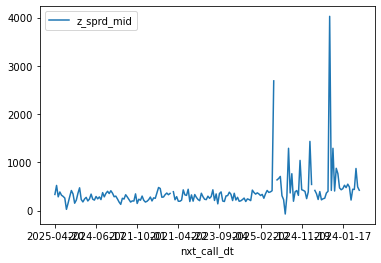

In [30]:
# plot maturity vs spread as a simple example directly from pandas
#bondData.plot(x='nxt_call_dt', y='z_sprd_mid',kind='scatter')
bondData.plot(x='nxt_call_dt',y='z_sprd_mid')



### a vertical bar chart

time taken:  0.26


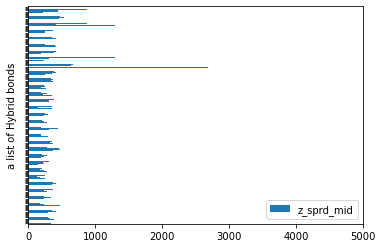

In [32]:
# plot a bar chart of the same data
# bondData.plot.bar(x='nxt_call_dt',y='z_sprd_mid')
t1 = time.time()


chart = bondData.plot(x='nxt_call_dt',y='z_sprd_mid', kind='barh')
chart.set_xlim(0,5000)

# change the y label
chart.set_ylabel('a list of Hybrid bonds')

# remove the y tick labels
chart.set_yticklabels([])




t2 = time.time()
print('time taken: ',round(t2-t1,2))





In [34]:
#bondData.hist(x='nxt_call_dt',y='z_sprd_mid')



### a histogram of the z spreads in the hybrid space

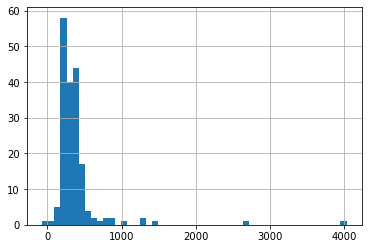

In [36]:
# convert to numeric
z_sprd_mid = pd.to_numeric(bondData['z_sprd_mid'])
yas_ispread = pd.to_numeric(bondData['yas_ispread'])


df = pd.DataFrame({
    'yas_ispread': yas_ispread,
    'z_sprd_mid':z_sprd_mid
    })

#hist = df['yas_ispread'].hist(bins=50)
#hist1 = df['z_sprd_mid'].hist(bins=50)


hist3 = bondData['z_sprd_mid'].hist(bins=50)




# Here are some statistics


In [38]:
# the average spread
x= bondData['z_sprd_mid'].mean()
x = round(x, 2)
print('the average z spread is:', x)


y= bondData['z_sprd_mid'].std()
y = round(y)
print('the standard deviation is:', y)

x, y = bondData['z_sprd_mid'].min() , bondData['z_sprd_mid'].max()
x, y = round(x), round(y)
print('min, max = ', x,",", y)

s = bondData['z_sprd_mid'].sem()
s = round(s,2)
print('standard error', s)



the average z spread is: 378.16
the standard deviation is: 374.0
min, max =  -69 , 4028
standard error 27.68


# lets get a regression

use the linear regression model in sklearn to get the linear regression.
example is here:


In [40]:
# linear regression

reg = linear_model.LinearRegression()

dependentVariables = bondData['nxt_call_dt'].values.reshape((-1,1))
independentVariables = bondData['z_sprd_mid'].values

# reg.fit(reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2]))

# model = reg.fit(dependentVariables,independentVariables)
# print(model)



# bonds crossing one year
This will be moved to a new module specifically for corporate hybrids.


In [42]:
# this will be moved to the hybrids module.



In [44]:
# oneYearBonds(bondData)

In [46]:
# delete the module so that it can be restarted for testing.
if 'hybridsMethods' in sys.modules:
    print('hybridsMethods was loaded')
    del sys.modules["hybridsMethods"]
    print('the module is now removed')


In [48]:
# import the hybrids module for testing
import hybridsMethods as hm

In [50]:

hm.oneYearBonds(100)



the hybrids module has been invoked
new things


0

# Other not used code...


In [52]:
def examples():
    """
    examples of how to get basic data from bbg
    """

    # get some data for a single name
    x = blp.bdp('BDEV LN Equity', 'px_last')
    print(x)
    print('the type of x', type(x))
    print('the value of x:', x.iloc[0]['px_last'])


    # get multiple data for a single name
    y = blp.bdp('BDEV LN Equity', flds=['px_bid', 'px_ask'])
    print(y)


    # get multiple data for multiple names
    z = blp.bdp(tickers=['BDEV LN Equity', 'BARC LN Equity'], flds=['px_bid', 'px_ask'])
    print(z)
    print('here is the bdev ask >>>', z.loc['BDEV LN Equity','px_ask'])



In [54]:
def get_bonds():
    """
    function to get bond data from bloomberg using tickers in an excel sheet.

    return:
        data - a pandas data set
    """

    print('getting bond data...')
    # securtiyList = ['US29265WAA62 Corp', 'XS1713463559 Corp', 'XS2000719992 Corp', 'XS0954675129 Corp', 'XS0954675129 Corp']
    fieldList = ['ticker', 'coupon', 'nxt_call_dt', 'final_maturity', 
                'mty_typ', 'px_mid', 'z_sprd_mid', 'yas_ispread', 'yas_bond_yld', 
                'yas_risk','crncy', 'payment_rank', 'industry_sector','rtg_moody','rtg_sp']

    # the script fis here
    #dir_path = os.path.dirname(os.path.realpath(__file__))
    dir_path = os.path.abspath('')


    # get items from sheet (in the same folder)
    fileToGet = 'hybridSecurityList.xlsx'
    # join file and correct folder
    fileToGet = os.path.join(dir_path, fileToGet)
    secListXlsx = pd.ExcelFile(fileToGet)
    
    # the names of the available sheets
    print('getting security list from:', secListXlsx.sheet_names)
    df = pd.DataFrame(secListXlsx.parse('tickers'))
    print('summary of the data')
    print(df.info)
    
    # put all isin's in a list
    isin = df.iloc[:,1].tolist()
    securtiyList = [x + " Corp" for x in isin]

    # make the lists unique (and keep the order)
    securtiyList = list(collections.OrderedDict.fromkeys(securtiyList))

    # get the data from bloomberg
    print('getting data from bbg')
    bondData = getListDataFromBbg(securtiyList, fieldList)

    #print('number of columns:', data.head())
    print('data is fetched:')
    print(bondData.info)

    return bondData

In [56]:
def main():

    # measure time for some basic examples
    t1 = time.time()
    
    # basic example (not used now)
    #examples()
    
    bondData = get_bonds()    
    t2 = time.time()

    # save data to file
    isStored = store_data(bondData)

    t3 = time.time()


    print('the time take is:', round(t2-t1, 3) , 'seconds')


In [58]:
# this works the same in a jupyter notebook which runs commands in sequence.
# there is no hoisting unless the code is added to a main() function.


if __name__ == "__main__":
    #main()
    pass




In [60]:
os.system('jupyter nbconvert --to html hybridsAnalysis 03.ipynb')


-1